# Quantum Channel for the Ancilla Density Matrix in Random Unitary Circuit

![](MPS.png)

We are going to evaluate the effect of the matrices along the diagonal slice on the ancilla density matrix. After summing over the indices $(s_1,s_2)$ for a neighbouring pair of sites we lose the final layer by unitarity, and we are left with:

![](cptp.png)

1. Trace over the first index of $R^{(j)}$
  
  $$
    R^{(j)}_{a_{1:D},a'_{1:D}}\rightarrow \sum_{a}R^{(j)}_{a a_{1:D-1},a a'_{1:D-1}}
  $$
  
  This reduces the number of indices of $R^{(j)}$ to $2(d-2)$, or $q^{2(d-2)}$ components.

2. Apply the unitaries $U_{d-1}$ and $\bar U_{d-1}$. This increases the rank of the resulting tensor back to $2(d-1)$.

3. Continue applying unitaries from the __middle out__ for $j=d-2,\ldots 2$.

4. Apply $U_1$ and $U^\dagger_1$, with the outer indices fixed.

In [1]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

In [2]:
from ruc import (cptp_map, next_step, tensor_trace, trace_square, matrix_to_tensor, 
                        tensor_to_matrix, random_ρ, random_gates, random_state, inner_product)

## Einsum path optimization

In [3]:
q = 2
depth = 3
gates = random_gates(q, depth)
ρ = random_ρ(q, depth)
path = np.einsum_path('aACx,bBCy,ab...->AB...xy', gates[0], gates[0].conj(), ρ, optimize='greedy')

In [4]:
print(path[0])

['einsum_path', (0, 1), (0, 1)]


In [5]:
print(path[1])

  Complete contraction:  aACx,bBCy,abzPIR->ABzPIRxy
         Naive scaling:  11
     Optimized scaling:  10
      Naive FLOP count:  6.144e+03
  Optimized FLOP count:  2.305e+03
   Theoretical speedup:  2.666
  Largest intermediate:  2.560e+02 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   7           bBCy,aACx->ABabxy                  abzPIR,ABabxy->ABzPIRxy
  10     ABabxy,abzPIR->ABzPIRxy                       ABzPIRxy->ABzPIRxy


In [6]:
path = np.einsum_path('aACx,bBDy,CDab...->AB...xy', gates[0], gates[0].conj(), ρ, optimize='greedy')

In [7]:
print(path[0])

['einsum_path', (0, 2), (0, 1)]


In [8]:
print(path[1])

  Complete contraction:  aACx,bBDy,CDabIR->ABIRxy
         Naive scaling:  10
     Optimized scaling:  8
      Naive FLOP count:  3.072e+03
  Optimized FLOP count:  1.025e+03
   Theoretical speedup:  2.997
  Largest intermediate:  6.400e+01 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   8         CDabIR,aACx->ADIRbx                      bBDy,ADIRbx->ABIRxy
   8         ADIRbx,bBDy->ABIRxy                           ABIRxy->ABIRxy


In [9]:
path = np.einsum_path('Cx,Dy,CD...->...xy', gates[-1][0, 0], gates[-1][0, 0].conj(), ρ, optimize=True)

In [10]:
print(path[0])

['einsum_path', (0, 2), (0, 1)]


In [11]:
print(path[1])

  Complete contraction:  Cx,Dy,CDzPIR->zPIRxy
         Naive scaling:  8
     Optimized scaling:  7
      Naive FLOP count:  7.680e+02
  Optimized FLOP count:  5.130e+02
   Theoretical speedup:  1.497
  Largest intermediate:  6.400e+01 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   7           CDzPIR,Cx->DIPRxz                        Dy,DIPRxz->zPIRxy
   7           DIPRxz,Dy->zPIRxy                           zPIRxy->zPIRxy


## Complexity

Don't forget that __depth__ is the number of gates, one more than the number of indices

In [12]:
timeit_results = []
q = 2
depths =  np.arange(5,13)
for d in depths:
    res = %timeit -o cptp_map(random_ρ(q, d - 1), random_gates(q, d))
    timeit_results.append(res.average)

1.1 ms ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.4 ms ± 9.33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.02 ms ± 47.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.34 ms ± 41 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.01 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
51.2 ms ± 2.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
317 ms ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.27 s ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Check the $4^d$ scaling

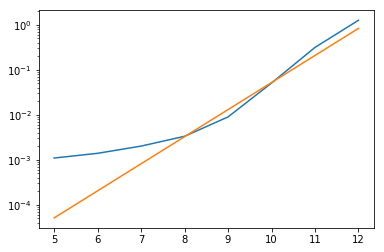

In [15]:
plt.semilogy(depths, timeit_results, depths, 0.00000005*4**depths)

## CPTP map simulation

In [3]:
q = 2
purities = []
depths = np.arange(5, 11)
for d in depths:
    
    print("depth: ", d)
    ρ = random_ρ(q, d - 1)
    purity_trace = np.array([])
    eigenvalues = np.array([])

    for step in range(1000):
        purity_trace = np.append(purity_trace, trace_square(ρ))
        eigenvalues = np.concatenate([eigenvalues, eigh(tensor_to_matrix(ρ), eigvals_only=True)])
        ρ = cptp_map(ρ, random_gates(q, d))
    
    purities.append(-np.log(np.mean(purity_trace)))

depth:  5
depth:  6
depth:  7
depth:  8
depth:  9
depth:  10


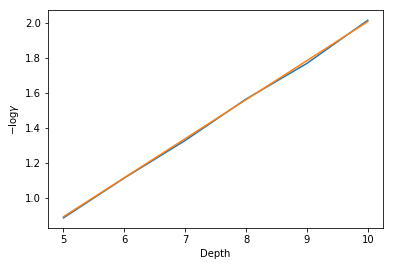

In [11]:
plt.plot(depths, purities)
plt.plot(depths, (depths - 1) * np.log(5/4))
plt.xlabel("Depth")
plt.ylabel("$-\log\gamma$");

Fits nicely with the predicted $(4/5)^t$ behaviour of the purity!

## Purity from CPTP map

In [5]:
np.mean(purity_trace)

(0.13320734449324811-1.8874435759237615e-18j)

In [6]:
-np.log(np.mean(purity_trace))

(2.015848383557739+1.416921554216127e-17j)

In [9]:
-np.log((4/5)**9)

2.0082919618278874

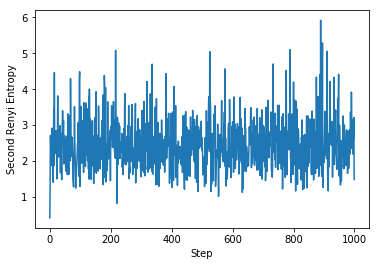

In [41]:
plt.plot(-np.log(np.real(purity_trace)))
plt.xlabel("Step")
plt.ylabel("Second Renyi Entropy");

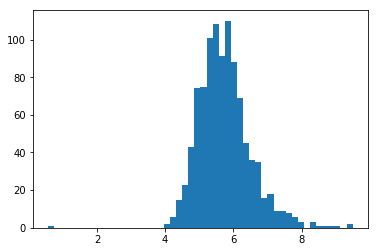

In [24]:
plt.hist(-np.log(np.real(purity_trace)), bins=50);

## Spectrum

/Users/austenlamacraft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
/Users/austenlamacraft/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/austenlamacraft/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


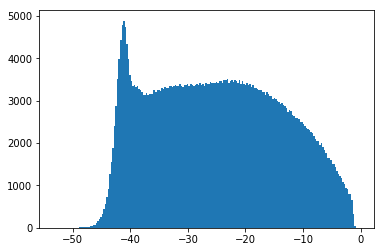

In [10]:
plt.hist(np.log(eigenvalues), bins=200);

Compare with fully random density matrix

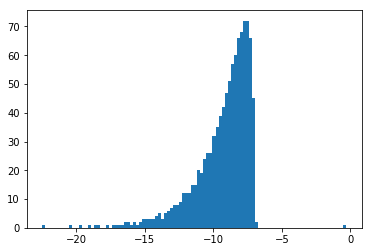

In [26]:
plt.hist(np.log(eigh(tensor_to_matrix(random_ρ(2, 10)), eigvals_only=True)), bins=100);

## Purity from Trajectories

Now we try it the second way using the relationship

$$
\gamma = \mathrm tr\left[\rho_A^2\right] = \mathbb{E}|\langle\psi_{x_1:x_N}|\psi_{y_1:y_N}\rangle|^2
$$

where $|\psi_{x_1:x_N}\rangle$ represents a normalized ancilla state arising from the trajectory $x_1:x_N$, where each step of the trajetory consists of a pair $x_j=(x^{(1)}_j, x^{(2)}_{j})$, where $x^{(1,2)}_j\in 1,\ldots q$. It is important that the trajectories are sampled from the probabilites corresponding to the ancilla states followed.

__Note__ that this way requires one extra unitary as we don't do the sum over $x_j$.

In [26]:
import time

In [34]:
q = 2
purities_traj = []
depths = np.arange(5, 16)
for d in depths:
    
    print("Depth: ", d)
    print(time.ctime())
    state1 = random_state(q, d - 1)
    state2 = state1
    purity_traj = np.array([])

    for step in range(10000):
        purity_traj = np.append(purity_traj, np.abs(inner_product(state1, state2))**2)
        gates = random_gates(q, d) 
        probs1, states1 = next_step(state1, gates)
        probs2, states2 = next_step(state2, gates)
        state1 = states1[np.random.choice(range(q**2), p=probs1)]
        state2 = states2[np.random.choice(range(q**2), p=probs2)]
    
    purities_traj.append(np.mean(purity_traj))


Depth:  5
Tue Feb  5 12:47:53 2019
Depth:  6
Tue Feb  5 12:48:02 2019
Depth:  7
Tue Feb  5 12:48:12 2019
Depth:  8
Tue Feb  5 12:48:25 2019
Depth:  9
Tue Feb  5 12:48:41 2019
Depth:  10
Tue Feb  5 12:49:06 2019
Depth:  11
Tue Feb  5 12:49:48 2019
Depth:  12
Tue Feb  5 12:51:02 2019
Depth:  13
Tue Feb  5 12:53:31 2019
Depth:  14
Tue Feb  5 12:58:42 2019
Depth:  15
Tue Feb  5 13:09:35 2019


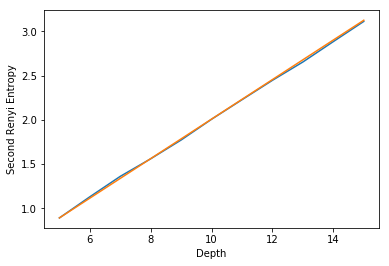

In [37]:
plt.plot(depths, -np.log(purities_traj))
plt.plot(depths, (depths - 1) * np.log(5/4))
plt.xlabel("Depth")
plt.ylabel("Second Renyi Entropy");

In [20]:
-np.log(np.mean(purity_traj))

3.1926721845740422

In [19]:
-14*np.log(4/5)

3.124009718398936